# Introduction à l'apprentissage automatique par le calcul de régression linéaire

Le calcul d'une droite de régression linéaire est ici l'occasion d'expérimenter des premiers calculs d'apprentissages automatiques (en anglais *machine learning*).

Dans ce texte, nous nous limitons à un recherche à un seul facteur, ici il s'agit de trouver la corrélation entre les loyers d'un appartement et leur surface.

Nous commençons par rappeler la calcul classique des paramètres de la droite de regression linéaire par les outils statistiques. Puis nous montrons la solution utilisant l'algorithme du gradient comme montré sur le blog de Thibault [Miximum](https://www.miximum.fr/blog/premiers-tests-avec-le-machine-learning/). Enfin nous terminons en montrant l'utilisation de l'extension d'apprentissage automatique [SciKit Learn](https://scikit-learn.org/stable/index.html) toujours pour résoudre ce problème.


Dans son blog, Thibault propose comme fichier de données, les loyers des appartements à Montpellier en 1995 en fonction de leur surface. Ce [fichier](loyers_montpellier_2015.csv) a été recopié sur ce répertoire. Il a été obtenu par Thibault sur le site de  [l'observatoire national des loyers](https://www.data.gouv.fr/fr/datasets/resultats-nationaux-des-observatoires-locaux-des-loyers/).

Je lis ce fichier en utilisant l'extension [pandas](https://pandas.pydata.org/).

In [63]:
import pandas as pd
df = pd.read_csv('loyers_montpellier_2015.csv')
df[:5]

,surface,loyer_mensuel
0,25,370
1,25,370
2,26,430
3,26,423
4,26,424


On afficher ces données sous formes d'un nuage de points (voir [ici](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) pour plus d'information). La commande `regplot` de l'extension [seaborn](https://www.geeksforgeeks.org/python-seaborn-regplot-method/) affiche directement le nuage de point et sa droite de régression.

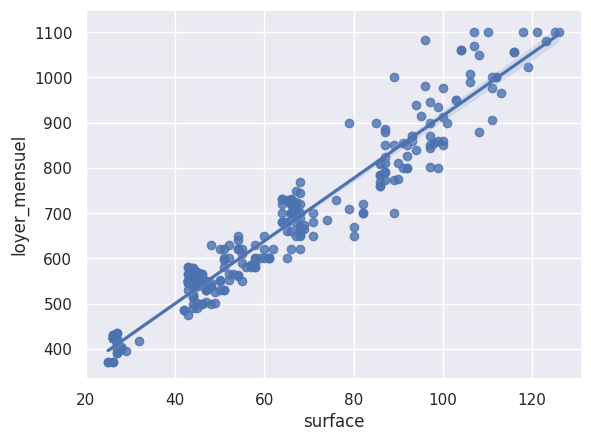

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# style seaborn
sns.set_theme(style="darkgrid")

# plt.plot(df['surface'], df['loyer_mensuel'], 'bo')
sns.regplot(x='surface',y='loyer_mensuel', data=df)
plt.show()


Nous allons maintenant recalculer les coefficients de cette droite de régression.

# Résolution en utilisant l'extension `statistics`

Les [calculs théoriques](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire) donne l'équation de droite de régression linéaire.

$$ y = \beta_0 + \beta_1 \times x $$

et les coefficients sont donnés par les équations suivantes.

$$
\begin{array}{ll}
\beta_1 & = \text{cov}(X,Y) / \text{var}(X) \\
\beta_0 & = \bar{y} - \beta_1 \times \bar{x} \\
\end{array}
$$

avec la définition usuelle des moyennes ($\bar{y}$, $\bar{y}$), de la covariance et de la variance.

$$
\begin{align*}
&\bar{x}         = \frac{1}{n} \sum_{i=1}^n x_i \\
&\text{var}(X)   = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2 \\
&\text{cov}(X,Y) = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) \\ 
\end{align*}
$$

L'extension [statistics](https://docs.python.org/3/library/statistics.html) permet de faire ces calculs directement avec la commande [linear_regression](https://docs.python.org/fr/dev/library/statistics.html?highlight=linear_regression#statistics.linear_regression). Par contre, il faudra auparavant traduire les données de mon dataframe en listes.

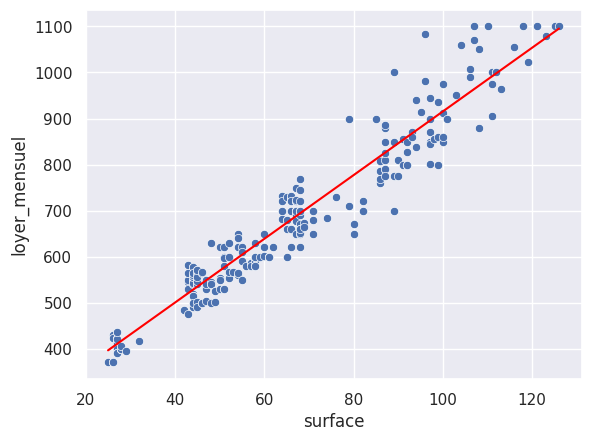

In [65]:
import statistics as stat
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Je convertis les séries Pandas en listes pour les utiliser dans l'extension 'statistics'
surfaces = df['surface'].tolist()
loyers = df['loyer_mensuel'].tolist()
slope, intercept = stat.linear_regression(surfaces, loyers)

# Je construis ensuite les prédictions de la droite de régression.
# (pour pouvoir multiplier le vecteur surfaces par un float, il faut convertir ses éléments en float)
# stat_predict = np.float_(surfaces) * slope + intercept
# ou passer en nd array explictement
stat_predict = np.array(surfaces) * slope + intercept

# je définis un style seaborn un peu plus sympa
sns.set_theme(style="darkgrid")

# j'affiche (uniquement) le nuage de points
sns.scatterplot(x=df['surface'], y=df['loyer_mensuel'])

# j'affiche la ligne de régression
sns.lineplot(x=df['surface'],y=stat_predict, color='red')
plt.show()

La commande [stats.linregress](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html) du module SciPy fait la même chose en donnant quelques résultats supplémentaires (comme l'erreur standard). Pour être sûr d'avoir un résultat, je convertis ici les colonnes du dataframe en ndarray.

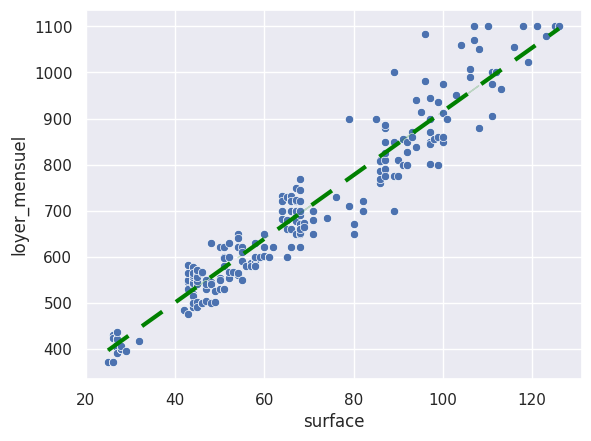

In [66]:
from scipy.stats import linregress

# conversion des colonnes du dataframe en ndarray
# x = np.array(surfaces)
# y = np.array(loyers)
x = df['surface'].to_numpy()
y = df['loyer_mensuel'].to_numpy()

sci_regres = linregress(x,y)
sci_predict = sci_regres.slope * x + sci_regres.intercept

# j'affiche le nuage de points (le dataframe permet d'avoir les titres des axes)
sns.scatterplot(x=df['surface'], y=df['loyer_mensuel'])

# j'affiche la ligne de régression
sns.lineplot(x=x,y=sci_predict, color='green', lw=3, dashes=[6,4])
plt.show()


# Faire une régression par la méthode du gradient avec Numpy

Le [cahier précédant](./00_concepts.ipynb) a présenté l'approche générale de l'apprentissage automatique en prenant justement comme exemple une régression linéaire. Je reprends ici ces résultats en utilisant donc NumPy. Je reprends cette méthode, tout en comparant avec la solution classique donnée par SciPy.

On commence par reprendre le `dataframe` précédant pour le convertir en un vecteur objectif `y` et une matrice d'échantillon `X`.

In [150]:
import numpy as np
import matplotlib.pyplot as plt

Les colonnes ont été traduites en `ndarray`, précédemment, mais attention, leur dimensions ne sont pas complètes car il s'agit de vecteur de dimension 1. Pour les méthodes matricielles qui vont suivre, `y` devra être de dimension `(303,1)` et `X` de dimension `(303,2)` (`303` est le nombre de lignes du tableau d'origine).

Je commence par une normalisation avec ici le transformer [MainMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [171]:
x = df['surface'].to_numpy()
y = df['loyer_mensuel'].to_numpy()
print(x.shape, y.shape)
L = len(y)

(303,) (303,)


La cellule suivante permet de tester l'effet de la normalisation des données.

In [172]:
preprocessing = False
if preprocessing:
    x_min = x.min()
    x_range = x.max() - x_min
    y_min = y.min()
    y_range = y.max() - y_min

    def transf(x, y):         
        return (x - x_min) / x_range , (y - y_min) / y_range

    def inv_transf(x,y):        
        return x * x_range + x_min, y * y_range + y_min
    
    def inv_transf_y(y):        
        return y * y_range + y_min

    # ces fonctions sont définies à la va-vite, on trouvera mieux ici:
    # voir https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.inverse_transform
    x,y = transf(x, y)


In [173]:
from tabulate import tabulate

x_vis = np.hstack(('surface',x[:5]))
y_vis = np.hstack(('loyer',y[:5]))

print(tabulate((x_vis, y_vis), tablefmt='rounded_grid'))

# for i,j in zip(x[:8],y[:8]):
#     print(i,j)

╭─────────┬─────┬─────┬─────┬─────┬─────╮
│ surface │  25 │  25 │  26 │  26 │  26 │
├─────────┼─────┼─────┼─────┼─────┼─────┤
│ loyer   │ 370 │ 370 │ 430 │ 423 │ 424 │
╰─────────┴─────┴─────┴─────┴─────┴─────╯


In [174]:
# préparation de y qui doit être de dimension (303,1)
y = np.reshape(y,(L,1))

# préparation de X en ajoutant une colonne de 1
X = np.hstack((np.ones((L,1)),np.reshape(x,(L,1))))

print(f'y.shape={y.shape} / x.shape = {x.shape} / X.shape = {X.shape} / X[1,:]= {X[1,:]}')
# y[:3]

y.shape=(303, 1) / x.shape = (303,) / X.shape = (303, 2) / X[1,:]= [ 1. 25.]


On initialise les paramètres $\theta$ du modèle avec des valeurs aléatoires.

In [175]:
if preprocessing:
    rng = np.random.default_rng(6)
    theta = rng.random((2,1))
    inverted = False # see later, for last cell of this chapter
else:
    theta = np.array([10., 10.]).reshape(2,1)

print(np.around(theta, 3))

theta.shape

[[10.]
 [10.]]


(2, 1)

Le modèle sera ici la droite de régression. L'objectif est de retrouver ses paramètres $\theta$. 

Comme nous l'avons vu dans le [cahier précédant](./00_concepts.ipynb) nous  utilisons le produit matriciel [dot](https://numpy.org/doc/1.21/reference/generated/numpy.ndarray.dot.html) (il existe aussi la forme [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)).

In [176]:
def model(X, theta):
    '''
    X: matrice d'entrées, dimension (m,2)
    theta: paramètres, dimension (2,1)
    return: matrice colonne (m,1)

    il faut veiller au format de la sort#     print(i,j)ie avec reshape
    '''
    return X.dot(theta).reshape(X.shape[0],1)

print(model(X, theta).shape)
print(model(X, theta)[:3,0])

# visualisation du modèle choisi au hasard...
show_graph = False
if show_graph:
    # le nuage de points
    plt.scatter(x=df['surface'], y=df['loyer_mensuel'])
    # la ligne de régression de scipy
    plt.plot(df['surface'],sci_predict, color='green', lw=3, dashes=[6,4])
    
    # retransformer les points
    
    plt.plot(X[:,0], model(X,theta), color='r', linewidth=3)
    
    ax = plt.gca()
    ax.set_xlabel('surface')
    ax.set_ylabel('loyer')
    plt.show()

(303, 1)
[260. 260. 270.]


La fonction de coût

In [177]:
def cost_function(X, y, theta):
    m = y.shape[0]
    return 1 / (2*m) * np.sum(np.square(model(X,theta) -y))

cost_function(X, y, theta)

4241.2194719471945

Son gradient

In [178]:
def grad(X,y,theta):
    m = y.shape[0]
    return 1/m * X.T.dot(model(X, theta) -y)

grad(X,y,theta)

array([[-21.19141914],
       [654.13861386]])

La fonction de descente du gradient

In [179]:
def gradient_descent(X,y,theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X,y,theta)
        cost_history[i] = cost_function(X,y,theta)
    return theta, cost_history

On peut maintenant appliquer l'algorithme de descente du gradient.

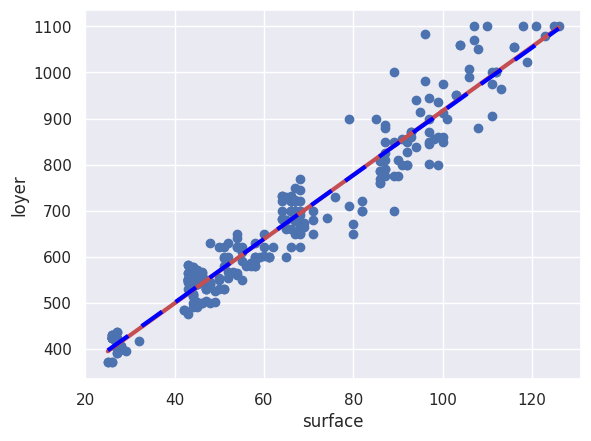

In [181]:
# paramètres fonctionnant pour les deux situations
if preprocessing:
    rate = 0.001
    nb_iterations = 50000
else:
    rate = 0.0001
    nb_iterations = 300000

theta_final, cost_history = gradient_descent(X,y,theta, learning_rate=rate, n_iterations=nb_iterations)
prediction = model(X, theta_final)

if preprocessing:    
    # pour visualiser, il faut revenir aux valeurs d'origine, mais qu'une seule fois
    if not inverted:
        x, y = inv_transf(x, y)
        prediction = inv_transf_y(prediction)
        inverted = True
    

plt.scatter(x,y)  # le nuage de point

# génération le droite de régressionpoints

plt.plot(x, prediction, c='r', lw=3)
plt.plot(x, stat_predict, c='blue', lw=3, dashes=[6,4]) # selon méthode précédente

ax = plt.gca()
ax.set_xlabel('surface')
ax.set_ylabel('loyer')
plt.show()

On contrôle la convergence de notre recherche.

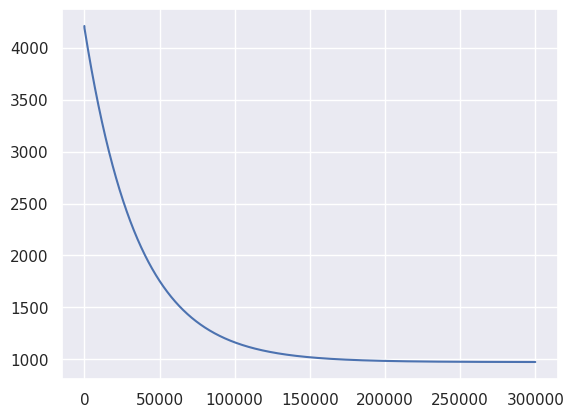

In [182]:
plt.plot(range(0,len(cost_history)), cost_history)

Calcul de la qualité de cette recherche.

In [183]:
def coef_determination(y, pred):
    u = np.square(y-pred).sum()
    v = np.square(y - y.mean()).sum()
    return 1 - u / v


In [184]:
coef = coef_determination(y, prediction)
print(f'Le coefficient de détermination de notre recherche est: {coef*100:.2f}%')

Le coefficient de détermination de notre recherche est: 94.04%


La convergence de la méthode du gradient est plus délicate avec les données non normées : il faut une vitesse de convergence plus petite et un plus grand nombre de pas pour assurer la convergence. On pourra faire des essais, mais penser à conserver les paramètres d'origine !

## Recherche avec des polynômes de degré supérieur

Nous avons du que l'on peut toujours utiliser cette méthode pour rechercher une solution avec un polynôme de degré supérieur.

In [ ]:
X = np.hstack((x, np.ones((L,1))))

Si nous reprenons l'expression exact de $J$ , les pas à effectuer sur $\theta_0$ et $\theta_1$ seront les suivants.

$$


\theta_0 \rightarrow \theta_0 - \alpha \times \frac{1}{m} \sum_{i=1}^m \left[ \theta_0 + \theta_1 \times x_i - y_i \right]
\quad ; \quad
\theta_1 \rightarrow \theta_1 - \alpha \times \frac{1}{m} \sum_{i=1}^m x_i\left[ \theta_0 + \theta_1 \times x_i - y_i \right]
$$


Notre fonction hypothèse, qui est donc ici une droite (mais on pourrait la remplacer par une autre courbe), s'appliquera au paramètres normalisés.

<Axes: xlabel='surface', ylabel='loyer_mensuel'>

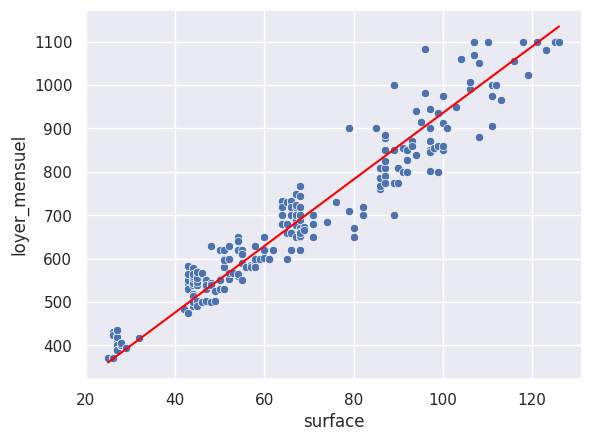

In [32]:
# theta est un tableau qui contient la liste des paramètres θ
def hypothesis(input, theta):
    return theta[0] + theta[1] * input    

def run_gradient_descent(x, y, theta):
    '''
      x est la liste de données d'entrée, les surfaces
      y est la liste des données de sorties, les loyers
      theta contient les paramètres du modèle en construction
    '''
    learning_rate = 0.0001  # c'est le paramètre α
    m = len(y)
    new_theta = theta

    # Mise à jour des paramètres theta à chaque tour
    nb_of_theta = len(theta)
    for t in range(nb_of_theta):
        # calcul des dérivées partielles de la fonction J
        errors = 0
        for i in range(m):
            if t == 0:
                errors += (hypothesis(x[i], theta) - y[i])
            else:
                errors += (hypothesis(x[i], theta) - y[i])*x[i]
        errors /= m

        # Mise à jour du paramètre theta en multipliant le taux
        # d'apprentissage (α) et la dérivée J'
        new_theta[t] = theta[t] - learning_rate * errors
    
    return new_theta

# ici on pourrait initialiser θ aléatoirement, mais je choisis de mettre 0 partout
theta = [0,0]
surfaces = df['surface'].tolist()
loyers = df['loyer_mensuel'].tolist()

NB_ITERATIONS = 100000

for i in range(NB_ITERATIONS):
    theta = run_gradient_descent(surfaces, loyers, theta)

intercept, slope = theta[0], theta[1]

# On construit les prédictions
predictions = []
for surf in surfaces:
    predictions.append(slope * surf + intercept)
# boucles obligatoires car surf est un float

# style seaborn
sns.set_theme(style="darkgrid")

# affichage du nuage de points
sns.scatterplot(x=df['surface'], y=df['loyer_mensuel'])

# affichage de la ligne de régression
sns.lineplot(x=df['surface'],y=predictions, color='red')

# sns.lineplot(x=x, y = stat_predict, color='blue', dashes=[(6,4)])

Cet algorithme n'est pas optimisé et on peut tester plusieurs valeurs du nombre d'itérations à réaliser. On voit qu'il faut au moins 10000 itérations pour commencer à obtenir une droite de régression correcte.

# Utiliser l'extension `SciKit Learn`



L'extension [SciKit Learn](https://scikit-learn.org/stable/index.html) offre plusieurs applications d'apprentissage automatique, dont la regression linéaire que nous venons de programmer. Mais bien sûr, cette extension est bien plus efficace que le programme que nous avons écrit plus haut. Cette extension possède [un sous module dédié aux regressions linéaires](https://scikit-learn.org/stable/modules/linear_model.html). 

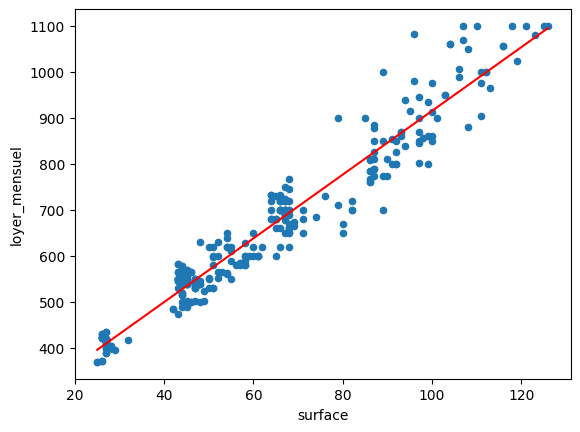

In [16]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(df[['surface']], df['loyer_mensuel'])

ax = df.plot.scatter(x='surface', y='loyer_mensuel', alpha=1)
ax.plot(df['surface'], lin.predict(df[['surface']]),c='red')

# Conclusion

La recherche d'une droite de régression linéaire peut être une première opportunité de tester un algorithme d'apprentissage automatique. L'extension [Scikit learn](https://scikit-learn.org/stable/modules/linear_model.html) montre qu'il y a bien d'autres possibilités.

Notre algorithme « fait maison » nous a aussi ouvert la mécanique interne de l'un de ces algorithmes d'apprentissages automatiques. Comme les autres, il inclue une méthode de recherche d'optimum, qui elle-même fait l'objet de beaucoup d'autres développements à une époque où on ne parlait pas encore d'apprentissage automatique.

